The purpose of our analysis is to estimate with extreme precision our target: thus, we decide to rely on a public dataset.

The dataset has been downloaded from ISTAT, and contains official demographic information about all Italian population.

Link: http://dati.istat.it/Index.aspx?DataSetCode=DCIS_POPRES1#

The problem of this dataset is that data are redundant, as many parts of the population are repeated.
The territory column is divided bycountry, containing all information at the highest level, then geographical area, regions and provinces. As a result, italian people is counted too many times (the sum of the column "value" does not correspond to the italian population, which is approximately 60 million people). Moreover, it is available the distinction between gender and civil status: after every distinction the total is reported, and this duplicates again the values of the population. 

Finally, the column ETA1 has been reported badly: for each region there is the same year reported many times, along with the sum of all components. 

# Steps that we follow:

## 1) Estimate the age distribution at provincia-level 

It is the less aggregated type of data we could get on age.

## 2) Find the % of people in our target in all italian cities

Our target is people between 25 and 44 years.

## 3) Find the % of people interested in politics

## 4) Find the target by municipality

# 1. Age distribution
### 1.1 Cleaning the dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_complete = pd.read_csv("Istat_italian_population.csv")#updated to 2018

#dropping manually the duplicate entries (-> keeping only the total values), dropping useless columns
df_complete = df_complete[(df_complete["Sesso"]=="totale")&(df_complete["ETA1"]!="Y_GE100")&(df_complete["Stato civile"]=="totale")&(df_complete["Età"]!="totale")].drop(["ITTER107","TIPO_DATO15",'SEXISTAT1',"Seleziona periodo",'Sesso','Tipo di indicatore demografico','STATCIV2','Stato civile','Flags','Flag Codes'], axis=1)

#cleaning the age column
def clean_year(text):
    return int(text.split(" ")[0])

df_complete['Età']=df_complete["Età"].apply(lambda x: clean_year(x))
df_complete.head()

Territorio ETA1  Età  TIME   Value
5       Italia   Y0    0  2018  456192
11  Nord-ovest   Y0    0  2018  119972
17    Piemonte   Y0    0  2018   30575
23      Torino   Y0    0  2018   15922
29    Vercelli   Y0    0  2018    1135

In [3]:
df_complete.groupby("Territorio").sum().sort_values(by="Value", ascending=False).head()
#remove the double entries,like Italia, Sud,Centro. etc

Età    TIME     Value
Territorio                        
Italia      4950  201800  60468326
Nord-ovest  4950  201800  16090908
Sud         4950  201800  14019441
Centro      4950  201800  12046663
Nord-est    4950  201800  11637667

In [4]:
da_togliere = ['Abruzzo',
'Basilicata',
'Calabria',
'Campania',
'Emilia-Romagna',
'Friuli-Venezia Giulia',
'Lazio',
'Liguria',
'Lombardia',
'Marche',
'Molise',
'Piemonte',
'Puglia',
'Sardegna',
'Sicilia',
'Toscana',
'Trentino Alto Adige / Südtirol',
'Umbria',
"Provincia Autonoma Trento",
"Provincia Autonoma Bolzano / Bozen",
'Veneto',
"Nord-ovest",
"Nord-est",
"Isole",
"Centro",
"Sud",
"Italia",
"Valle d'Aosta / Vallée d'Aoste"] #the two Provincie autonome are duplicates too

#using tilda to reverse the boolean mask and keep all that is not in "da_togliere"
df_complete = df_complete[~df_complete['Territorio'].isin(da_togliere)] 
df_complete=df_complete.reset_index().iloc[:,[1,3,5]] # selecting only columns I want
df_complete.rename(columns={"Territorio":"Provincia","Value":"Popolazione"}, inplace=True)
df_complete.groupby("Provincia").count().head()

Età  Popolazione
Provincia                      
Agrigento      100          100
Alessandria    100          100
Ancona         100          100
Arezzo         100          100
Ascoli Piceno  100          100

In [5]:
df_complete['Popolazione'].sum()

60342151

### 1.2 Computing the empirical age cdf by provincia

In [6]:
df_cdf=df_complete.groupby(["Provincia","Età"]).sum().reset_index() #df with all ages by province
df_provincia=df_cdf.groupby("Provincia").sum().reset_index() #df with total number of people by province
df_provincia=df_provincia.iloc[:,[0,2]]
df_provincia.head()

Provincia  Popolazione
0      Agrigento       438170
1    Alessandria       423998
2         Ancona       472464
3         Arezzo       343356
4  Ascoli Piceno       208314

In [7]:
df_cdf.head()

Provincia  Età  Popolazione
0  Agrigento    0         3373
1  Agrigento    1         3322
2  Agrigento    2         3378
3  Agrigento    3         3601
4  Agrigento    4         3484

In [8]:
df_cdf=df_cdf.merge(df_provincia, how="left",left_on="Provincia",right_on="Provincia") #merging the two tables
df_cdf.rename(columns={"Popolazione_x":'Popolazione_età','Popolazione_y':'Popolazione_tot'},inplace=True) #renaming columns
df_cdf=df_cdf[df_cdf['Età'].isin(range(25,45))] #filtering for our target: people between 25 and 44
df_cdf['distribution'] = df_cdf['Popolazione_età']/df_cdf['Popolazione_tot'] #computing the probability that people from a province is x years old
df_cdf.head()

Provincia  Età  Popolazione_età  Popolazione_tot  distribution
25  Agrigento   25             5552           438170      0.012671
26  Agrigento   26             5365           438170      0.012244
27  Agrigento   27             5548           438170      0.012662
28  Agrigento   28             5360           438170      0.012233
29  Agrigento   29             5488           438170      0.012525

In [9]:
df_distribution=df_cdf.groupby("Provincia").sum() #grouping by province
df_distribution=df_distribution.iloc[:,[1,3]]
df_distribution.rename(columns={"Popolazione_età":"Target 25-44"},inplace=True)
df_distribution.sort_values(by="distribution")
df_distribution.reset_index(inplace=True)
df_distribution=df_distribution.iloc[:,[0,2]]
df_distribution.head()

Provincia  distribution
0      Agrigento      0.251569
1    Alessandria      0.220831
2         Ancona      0.239906
3         Arezzo      0.240054
4  Ascoli Piceno      0.236878

## 2. Applying the Provincia age distribution to the municipalities

In [10]:
#This table from Istat contains all the municipalities and the province
df_comuni=pd.read_excel("Elenco-comuni-italiani.xlsx",sep=",")
df_comuni = df_comuni.iloc[:,[6,9,10,11]]
df_comuni.rename(columns={"Denominazione in italiano":"Comune","Denominazione regione":"Regione","Denominazione dell'Unità territoriale sovracomunale \n(valida a fini statistici)":"Provincia"}, inplace=True)
df_comuni.head()

Comune Ripartizione geografica   Regione Provincia
0            Agliè              Nord-ovest  Piemonte    Torino
1          Airasca              Nord-ovest  Piemonte    Torino
2     Ala di Stura              Nord-ovest  Piemonte    Torino
3  Albiano d'Ivrea              Nord-ovest  Piemonte    Torino
4           Almese              Nord-ovest  Piemonte    Torino

In [11]:
#this table contains the municipality and the population number
df_pop = pd.read_excel("popolazione_comuni.xlsx")
df_pop.columns = df_pop.iloc[0]
df_pop=df_pop.reindex(df_pop.index.drop(0))
df_pop.head()

0             Comune Popolazione
1              Agliè        2646
2            Airasca        3726
3       Ala di Stura         456
4    Albiano d'Ivrea        1677
5    Alice Superiore         725

In [12]:
df_pop['Comune'][7699][:2]=="  "
# I have to drop this

True

In [13]:
def remove_whitespace(txt):
    return txt.split('  ')[-1]
df_pop['Comune']=df_pop['Comune'].apply(lambda x: remove_whitespace(x))

In [14]:
df_pop=df_pop.sort_values(by="Comune")
df_pop=df_pop.drop_duplicates()
df_pop=df_pop.reset_index().iloc[:,1:]
df_pop=df_pop[df_pop['Popolazione']!=".."]
print(len(df_pop))
df_comuni=df_comuni.sort_values(by="Comune")
df_comuni=df_comuni.drop_duplicates()
df_comuni=df_comuni.reset_index().iloc[:,1:]
print(len(df_comuni))

7979
7915


In [15]:
df_comuni[df_comuni['Comune']=="Ponte Gardena"]

Comune Ripartizione geografica                       Regione  \
5277  Ponte Gardena                Nord-est  Trentino-Alto Adige/Südtirol   

          Provincia  
5277  Bolzano/Bozen

In [16]:
#merging does not work well.Why?
def whats_wrong(df1,df2):
    s1=set(df1['Comune'].values.tolist())
    s2=set(df2['Comune'].values.tolist())
    mismatch=s1.union(s2)-s1.intersection(s2)
    return mismatch
#that's why!!!
#df_pop has some municipalities with "/"
whats_wrong(df_pop,df_comuni)

{'Aldino',
 'Aldino/Aldein',
 'Alice Superiore',
 'Alluvioni Cambiò',
 'Alluvioni Piovera',
 'Alta Val Tidone',
 'Alto Sermenza',
 'Andriano',
 'Andriano/Andrian',
 'Anterivo',
 'Anterivo/Altrei',
 'Appiano sulla strada del vino',
 'Appiano sulla strada del vino/Eppan an der Weinstraße',
 'Auditore',
 'Avelengo',
 'Avelengo/Hafling',
 'Badia',
 'Badia/Abtei',
 'Barbarano Mossano',
 'Barbarano Vicentino',
 'Barberino Tavarnelle',
 "Barberino Val d'Elsa",
 'Barbiano',
 'Barbiano/Barbian',
 'Berra',
 'Bigarello',
 'Bolzano',
 'Bolzano/Bozen',
 'Borgo Mantovano',
 'Borgo Valbelluna',
 'Borgo Veneto',
 'Borgocarbonara  ',
 'Borgofranco sul Po',
 'Braies',
 'Braies/Prags',
 'Breia',
 'Brennero',
 'Brennero/Brenner',
 'Brenzone',
 'Brenzone sul Garda',
 'Bressanone',
 'Bressanone/Brixen',
 'Bronzolo',
 'Bronzolo/Branzoll',
 'Brunico',
 'Brunico/Bruneck',
 "Ca' d'Andrea",
 'Cadrezzate',
 'Cadrezzate con Osmate',
 'Cagno',
 'Caines',
 'Caines/Kuens',
 'Caldaro sulla strada del vino',
 'Caldaro 

In [17]:
def fixing_txt(txt):
    return txt.split("/")[0]
df_pop['Comune']=df_pop['Comune'].apply(lambda x: fixing_txt(x))
whats_wrong(df_pop,df_comuni) #small municipalities

{'Alice Superiore',
 'Alluvioni Cambiò',
 'Alluvioni Piovera',
 'Alta Val Tidone',
 'Alto Sermenza',
 'Auditore',
 'Barbarano Mossano',
 'Barbarano Vicentino',
 'Barberino Tavarnelle',
 "Barberino Val d'Elsa",
 'Berra',
 'Bigarello',
 'Borgo Mantovano',
 'Borgo Valbelluna',
 'Borgo Veneto',
 'Borgocarbonara  ',
 'Borgofranco sul Po',
 'Breia',
 'Brenzone',
 'Brenzone sul Garda',
 "Ca' d'Andrea",
 'Cadrezzate',
 'Cadrezzate con Osmate',
 'Cagno',
 'Camairago',
 'Caminata',
 'Camo',
 'Campolongo sul Brenta',
 'Canevino',
 'Capaccio',
 'Capaccio Paestum',
 'Carbonara di Po',
 'Carpasio',
 "Casasco d'Intelvi",
 'Castelgerundo',
 'Castellar',
 'Castellinaldo',
 "Castellinaldo d'Alba",
 "Castiglione d'Intelvi",
 'Cavacurta',
 'Cavaglio-Spoccia',
 'Cellio',
 'Cellio con Breia',
 'Centro Valle Intelvi',
 'Cerreto Castello',
 'Chatillon',
 'Châtillon',
 'Cismon del Grappa',
 'Colceresa',
 'Colli Verdi',
 'Conco',
 'Corigliano Calabro',
 'Corigliano-Rossano',
 'Costermano',
 'Costermano sul Gard

In [18]:
# merging the two tables:
df_pot_mkt=df_comuni.merge(df_pop,how="left",left_on="Comune",right_on="Comune")
print(len(df_pot_mkt))

#some values in population have ".."
df_pot_mkt=df_pot_mkt[df_pot_mkt['Popolazione']!=".."]
df_pot_mkt['Popolazione'].sum()
#a little bit less because some municipalities were not included. They are very small though

7928


60116497

In [19]:
df_pot_mkt=df_pot_mkt[~df_pot_mkt['Popolazione'].isna()]
df_pot_mkt.isna().any()

Comune                     False
Ripartizione geografica    False
Regione                    False
Provincia                  False
Popolazione                False
dtype: bool

In [20]:
df_pot_mkt.head()

Comune Ripartizione geografica    Regione Provincia  \
0            Abano Terme                Nord-est     Veneto    Padova   
1        Abbadia Cerreto              Nord-ovest  Lombardia      Lodi   
2        Abbadia Lariana              Nord-ovest  Lombardia     Lecco   
3  Abbadia San Salvatore                  Centro    Toscana     Siena   
4              Abbasanta                   Isole   Sardegna  Oristano   

  Popolazione  
0       20101  
1         289  
2        3216  
3        6325  
4        2689

In [21]:
def whats_wrong2(df1,df2):
    s1=set(df1['Provincia'].values.tolist())
    s2=set(df2['Provincia'].values.tolist())
    mismatch=s1.union(s2)-s1.intersection(s2)
    return mismatch
whats_wrong2(df_pot_mkt,df_distribution)

{'Bolzano / Bozen',
 'Bolzano/Bozen',
 'Reggio Calabria',
 'Reggio di Calabria',
 "Valle d'Aosta/Vallée d'Aoste"}

In [22]:
def splitter1(txt): #for df_distribution
    return txt.split(" /")[0]
def splitter2(txt): #for df_pot_mkt
    return txt.split("/")[0]
df_distribution['Provincia']=df_distribution['Provincia'].apply(lambda x: splitter1(x))
df_pot_mkt['Provincia']=df_pot_mkt['Provincia'].apply(lambda x: splitter2(x))
df_distribution.at[76, 'Provincia'] = 'Reggio Calabria'
whats_wrong2(df_pot_mkt,df_distribution)

{"Valle d'Aosta"}

In [23]:
#Aosta does not appear inside the df_distribution -> giving to Aosta the mean
df_distribution['distribution'].mean()

0.24423038062578606

In [24]:
df_distribution.loc[-1] = ["Valle d'Aosta",df_distribution['distribution'].mean()]
df_distribution=df_distribution.reset_index().iloc[:,1:]
whats_wrong2(df_pot_mkt,df_distribution)

set()

### 2.1 Merging

In [25]:
df_final=df_pot_mkt.merge(df_distribution, how="left",left_on="Provincia",right_on="Provincia") #.isna().any()
print(len(df_final))
df_final.isna().any()

7865


Comune                     False
Ripartizione geografica    False
Regione                    False
Provincia                  False
Popolazione                False
distribution               False
dtype: bool

In [26]:
#now we have the age distribution in each province and the populazion size of each municipality
df_final['Young_people']=df_final["Popolazione"]*df_final['distribution']
df_final['Young_people']=df_final['Young_people'].apply(lambda x: int(round(x,0))) #rounding to unit and converting to integer
df_final.groupby("Regione").count().head()

Comune  Ripartizione geografica  Provincia  Popolazione  \
Regione                                                                   
Abruzzo            305                      305        305          305   
Basilicata         131                      131        131          131   
Calabria           402                      402        402          402   
Campania           548                      548        548          548   
Emilia-Romagna     324                      324        324          324   

                distribution  Young_people  
Regione                                     
Abruzzo                  305           305  
Basilicata               131           131  
Calabria                 402           402  
Campania                 548           548  
Emilia-Romagna           324           324

# 3. Measuring the interest toward politics 
### 3.1 Considering the number of people who voted at the last Parliament election

NB: because of the small size and the high discrepancy from the other tables, the dataset "scrutini-camera" has been previously manipulated in Excel. When double entries for Regions occurred (considering more than one election) we weighted the percentage with the number of voters. Data for Valle d'Aosta were not available in the same table, and we had to take them in another section of the same website.

link: https://elezionistorico.interno.gov.it/index.php?tpel=C&dtel=04/03/2018&tpa=I&tpe=A&lev0=0&levsut0=0&es0=S&ms=S

In [27]:
df_elezioni=pd.read_csv("scrutini-camera.csv",encoding='iso-8859-1',sep=";")
#df_elezioni=df_elezioni.reset_index()
df_elezioni=df_elezioni.rename(columns={"Ente":"Regione"})
df_elezioni=df_elezioni.iloc[:,[0,4]].dropna(subset=['Percentuale votanti']).reset_index().iloc[:,1:]
df_final=df_final.merge(df_elezioni,how="left",left_on="Regione",right_on="Regione")
df_final.head()

Comune Ripartizione geografica    Regione Provincia  \
0            Abano Terme                Nord-est     Veneto    Padova   
1        Abbadia Cerreto              Nord-ovest  Lombardia      Lodi   
2        Abbadia Lariana              Nord-ovest  Lombardia     Lecco   
3  Abbadia San Salvatore                  Centro    Toscana     Siena   
4              Abbasanta                   Isole   Sardegna  Oristano   

  Popolazione  distribution  Young_people Percentuale votanti  
0       20101      0.243368          4892          0,78734771  
1         289      0.254943            74         0,768725605  
2        3216      0.235895           759         0,768725605  
3        6325      0.237021          1499         0,774677056  
4        2689      0.241340           649          0,65510705

In [28]:
df_final['Percentuale votanti']=df_final['Percentuale votanti'].apply(lambda x: float(x.replace(",",".")))
df_final['Potential app users'] = df_final['Young_people']*df_final['Percentuale votanti']
df_final['Potential app users']=df_final['Potential app users'].apply(lambda x: int(round(x,0)))
df_final.sort_values(by="Potential app users",ascending=False).head()

Comune Ripartizione geografica    Regione Provincia Popolazione  \
5748     Roma                  Centro      Lazio      Roma     2872800   
3967   Milano              Nord-ovest  Lombardia    Milano     1366180   
4457   Napoli                     Sud   Campania    Napoli      966144   
7096   Torino              Nord-ovest   Piemonte    Torino      882523   
4807  Palermo                   Isole    Sicilia   Palermo      668405   

      distribution  Young_people  Percentuale votanti  Potential app users  
5748      0.257164        738782             0.726972               537074  
3967      0.254778        348073             0.768726               267573  
4457      0.267593        258534             0.683112               176608  
7096      0.236013        208287             0.751818               156594  
4807      0.259865        173695             0.627874               109059

{'whiskers': [<matplotlib.lines.Line2D at 0x1dfebbd65c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1dfebbd6c88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dfebbd6198>],
 'medians': [<matplotlib.lines.Line2D at 0x1dfebb21358>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dfebb216a0>],
 'means': []}

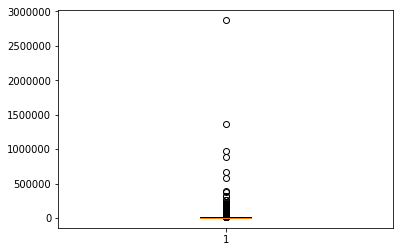

In [29]:
threshold=df_final.sort_values(by="Popolazione",ascending=False).reset_index().iloc[:,1:]
plt.boxplot(threshold['Popolazione'].values.tolist())

Pain points of our approach:

Because of data constraints we approximated the age distribution at provincia-level to estimate the number of people by municipality in our target. We used then the percentage of voters as a proxy for people interested in politics, and therefore willing to download a public administration app. Only regional data were available though. Moreover, we are applying the mean value of the %-voters distribution to our target (age 25-44), assuming that this percentage is constant across age and province. We know it is a pretty strong assumption but we did not find more detailed data.

# 4. Competition analysis:

We analyze Comuni-chiamo, whose website contains many information about the municipalities they're collaborating with.

### 4.1 Scraping the municipalities they're working with

In [30]:
import requests
from selenium import webdriver
import time
from time import sleep
from bs4 import BeautifulSoup

url = 'https://comuni-chiamo.com/entities'
driver = webdriver.Chrome(executable_path =r"C:\Users\vitto\OneDrive\Desktop\chromedriver.exe")
driver.get(url)

time.sleep(5) #letting the page upload
#closing the cookies
button = driver.find_element_by_class_name("iubenda-cs-close-btn") 
button.click()
#connecting
content = driver.page_source
soup = BeautifulSoup(content, "lxml")
#the information we want
lista1 = soup.find_all("span", {"class":"truncated"}) #finding the name of the municipality
lista2=soup.find_all("div",{'class':"population"}) #finding the number of people that live in the municipality
lista3=soup.find_all("div",{"class":'services-wrapper'}) #finding whether the app is already available in the municipality
#lists to create the dataframe later
comuni=[]
popolazione=[]
attivo=[]
for i in range(len(lista1)):
    comuni.append(lista1[i].get_text().replace("\n",""))
    popolazione.append(int(lista2[i].get_text().split("\t")[3].split(" ")[0].replace(".","")))
    #appending a dummy 0/1_ 0 if the app is not yet available, 1 if it is
    if lista3[i].get_text().strip() == "in arrivo":
        attivo.append(0)
    else:
        attivo.append(1)

In [31]:
comuni_chiamo = pd.DataFrame({'comune':comuni, "popolazione":popolazione, "servizio attivo":attivo})
comuni_chiamo.head()

comune  popolazione  servizio attivo
0               Adria        19000                0
1  Anzola dell'Emilia        12300                1
2           Avigliana        12500                1
3            Bagheria        56000                1
4           Baricella         7000                1

In [32]:
print("The average number of citizens comuni-chiamo is active is:",comuni_chiamo["popolazione"].mean())
print("The standard deviation of number of citizens is:",comuni_chiamo['popolazione'].std())
print("The biggest city they are active is",comuni_chiamo[comuni_chiamo['popolazione']==comuni_chiamo['popolazione'].max()]['comune'].values.tolist()[0],", which has",comuni_chiamo['popolazione'].max(),"citizens")

The average number of citizens comuni-chiamo is active is: 21634.314285714285
The standard deviation of number of citizens is: 46245.78086520939
The biggest city they are active is Bologna , which has 390128 citizens


### 4.2 Statistics without outliers

In [33]:
print("Without considering Bologna, Trieste and Parma, the mean of citizens is",comuni_chiamo.sort_values(by="popolazione",ascending=False).iloc[3:,:]['popolazione'].mean())
print("Without considering Bologna, Trieste and Parma, the standard deviation of citizens is",comuni_chiamo.sort_values(by="popolazione",ascending=False).iloc[3:,:]['popolazione'].std())

Without considering Bologna, Trieste and Parma, the mean of citizens is 14573.28431372549
Without considering Bologna, Trieste and Parma, the standard deviation of citizens is 13922.987553801657


Now I merge the comuni-chiamo dataframe with the other containing all information about the target. The purpose is to see how comuni-chiamo is doing.

In [34]:
#merging. We keep our column "Popolazione" which is more accurate.
comuni_chiamo=comuni_chiamo.merge(df_final,how="left",left_on="comune",right_on="Comune").iloc[:,[2,3,4,5,6,7,8,9,10,11]]
comuni_chiamo.head()

servizio attivo              Comune Ripartizione geografica  \
0                0               Adria                Nord-est   
1                1  Anzola dell'Emilia                Nord-est   
2                1           Avigliana              Nord-ovest   
3                1            Bagheria                   Isole   
4                1           Baricella                Nord-est   

          Regione Provincia Popolazione  distribution  Young_people  \
0          Veneto    Rovigo       19436      0.233632          4541   
1  Emilia-Romagna   Bologna       12310      0.245824          3026   
2        Piemonte    Torino       12443      0.236013          2937   
3         Sicilia   Palermo       55047      0.259865         14305   
4  Emilia-Romagna   Bologna        7030      0.245824          1728   

   Percentuale votanti  Potential app users  
0             0.787348                 3575  
1             0.782914                 2369  
2             0.751818                 2208  
3             0.627874                 8982  
4             0.782914                 1353

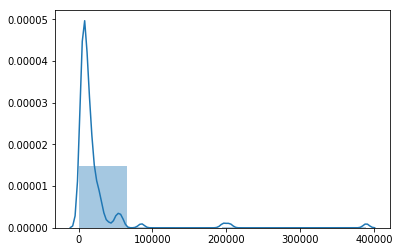

In [35]:
sns.distplot(comuni_chiamo['Popolazione'].values.tolist(), bins=6, hist=True)

### 4.3 Descriptive statistics and plots about Comuni-chiamo

In [36]:
comuni_chiamo.groupby("Ripartizione geografica").count().iloc[:,0].sort_values(ascending=False)

Ripartizione geografica
Nord-est      57
Nord-ovest    29
Sud            9
Isole          5
Centro         5
Name: servizio attivo, dtype: int64

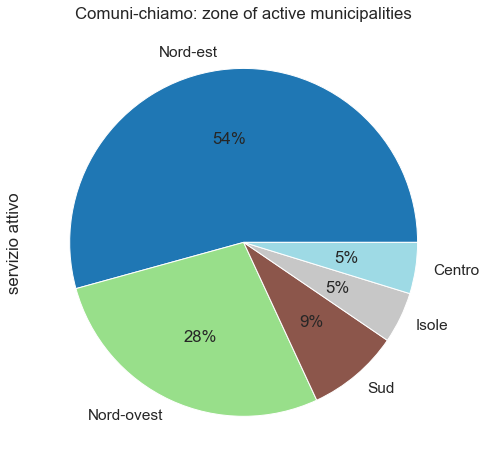

In [37]:
sns.set(font_scale=1.4)
comuni_chiamo.groupby("Ripartizione geografica").count().iloc[:,0].sort_values(ascending=False).plot(kind='pie', colormap ='tab20', stacked=True, title = "Comuni-chiamo: zone of active municipalities", autopct='%1.0f%%', figsize=(8,8))
plt.savefig("Comuni-chiamo_geozone.png")

In [38]:
comuni_chiamo_active=comuni_chiamo.groupby("Regione").count().iloc[:,0].sort_values(ascending=False)
comuni_chiamo_active=pd.DataFrame({"Region":comuni_chiamo_active.index, "Active_municipalities":comuni_chiamo_active.values})
comuni_chiamo_active

Region  Active_municipalities
0          Emilia-Romagna                     50
1               Lombardia                     20
2                Piemonte                      7
3                  Veneto                      4
4                Sardegna                      4
5                Calabria                      4
6   Friuli-Venezia Giulia                      3
7                 Toscana                      2
8                  Puglia                      2
9                 Liguria                      2
10                Abruzzo                      2
11                 Umbria                      1
12                Sicilia                      1
13                 Marche                      1
14                  Lazio                      1
15             Basilicata                      1

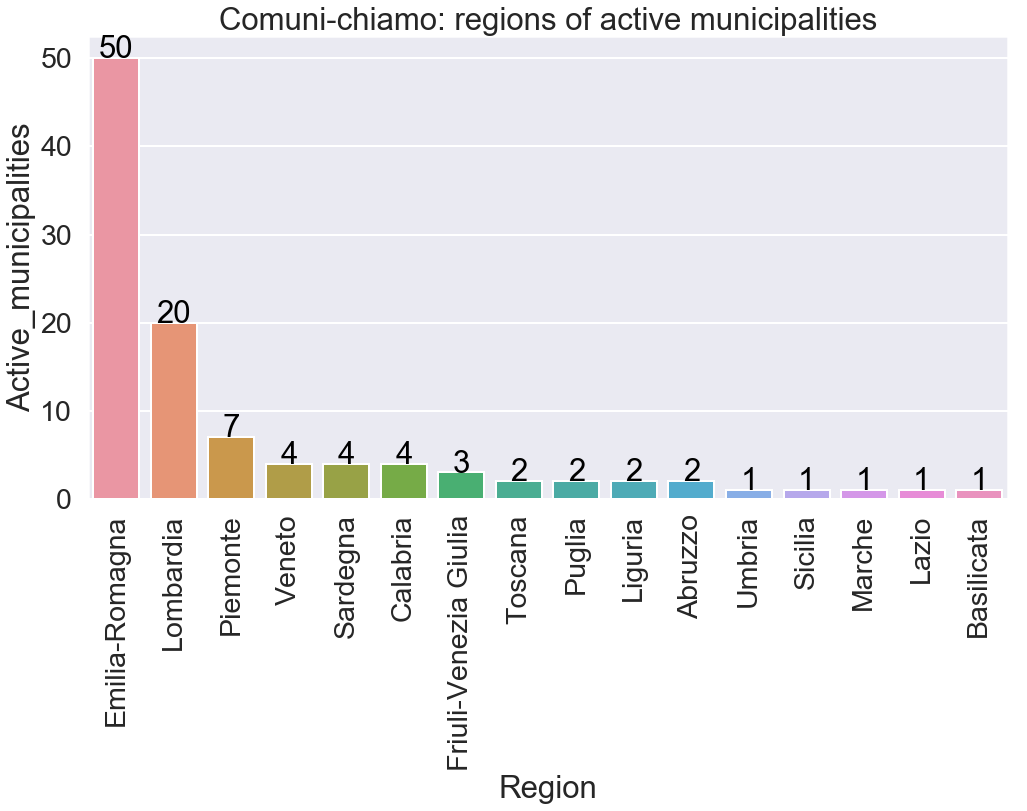

In [39]:
sns.set(style="darkgrid")
sns.set_context('poster',font_scale=1.3)
plt.figure(figsize=(15,12))

graph=sns.barplot(x=comuni_chiamo_active['Region'], y=comuni_chiamo_active['Active_municipalities'])

plt.title('Comuni-chiamo: regions of active municipalities')
for index, row in comuni_chiamo_active.iterrows():
    graph.text(x=row.name,y=row.Active_municipalities,s=row.Active_municipalities, color='black', ha="center")
plt.xticks(rotation='vertical')    
plt.tight_layout()
plt.savefig("Comuni-chiamo_active.png")

### 4.4 Combining the information about potential users with number of downloads

Comunichiamo downloads are in the category +10K. Thus, they can range between 10001 and 49999.

In [40]:
values = [10001,int((10001+49999)/2),49999]
cc_downloads=comuni_chiamo[comuni_chiamo['servizio attivo']==1].iloc[:,[1,2,3,4,5,7,9]]
conversion_rates=[]
for v in values:
    conversion_rates.append(v/cc_downloads['Potential app users'].sum())
conversion_rates

[0.025504297044347538, 0.07650524060898171, 0.1275061841736159]

In [41]:
cc_downloads['users_scenario_min']=(round(cc_downloads['Potential app users']*conversion_rates[0],0)).apply(lambda x: int(x))
cc_downloads['users_scenario_mean']=(round(cc_downloads['Potential app users']*conversion_rates[1],0)).apply(lambda x: int(x))
cc_downloads['users_scenario_max']=(round(cc_downloads['Potential app users']*conversion_rates[2],0)).apply(lambda x: int(x))
cc_downloads

Comune Ripartizione geografica                Regione  \
1        Anzola dell'Emilia                Nord-est         Emilia-Romagna   
2                 Avigliana              Nord-ovest               Piemonte   
3                  Bagheria                   Isole                Sicilia   
4                 Baricella                Nord-est         Emilia-Romagna   
5                    Baveno              Nord-ovest               Piemonte   
6                  Bellusco              Nord-ovest              Lombardia   
7               Bentivoglio                Nord-est         Emilia-Romagna   
8                   Bologna                Nord-est         Emilia-Romagna   
11                   Budrio                Nord-est         Emilia-Romagna   
12                  Busseto                Nord-est         Emilia-Romagna   
14    Casarsa della Delizia                Nord-est  Friuli-Venezia Giulia   
15          Casola Valsenio                Nord-est         Emilia-Romagna   
16       Cassina de' Pecchi              Nord-ovest              Lombardia   
17         Castel Bolognese                Nord-est         Emilia-Romagna   
18          Castel Maggiore                Nord-est         Emilia-Romagna   
19              Castelleone              Nord-ovest              Lombardia   
20        Castello d'Argile                Nord-est         Emilia-Romagna   
21      Castelnuovo Rangone                Nord-est         Emilia-Romagna   
22                Castenaso                Nord-est         Emilia-Romagna   
23       Castiglione d'Adda              Nord-ovest              Lombardia   
24                 Cavriago                Nord-est         Emilia-Romagna   
25             Celle Ligure              Nord-ovest                Liguria   
26                   Cervia                Nord-est         Emilia-Romagna   
27               Cesenatico                Nord-est         Emilia-Romagna   
28     Chiaravalle Centrale                     Sud               Calabria   
29               Cittadella                Nord-est                 Veneto   
30                  Colorno                Nord-est         Emilia-Romagna   
31                Copertino                     Sud                 Puglia   
32                  Copparo                Nord-est         Emilia-Romagna   
33           Cornate d'Adda              Nord-ovest              Lombardia   
..                      ...                     ...                    ...   
72                  Pianoro                Nord-est         Emilia-Romagna   
73           Pieve di Cento                Nord-est         Emilia-Romagna   
74           Pieve Emanuele              Nord-ovest              Lombardia   
75          Pieve Fissiraga              Nord-ovest              Lombardia   
77                Ponderano              Nord-ovest               Piemonte   
78              Porto Tolle                Nord-est                 Veneto   
79               Rescaldina              Nord-ovest              Lombardia   
80                      Rho              Nord-ovest              Lombardia   
81              Riolo Terme                Nord-est         Emilia-Romagna   
82           Sala Bolognese                Nord-est         Emilia-Romagna   
83      Salsomaggiore Terme                Nord-est         Emilia-Romagna   
84     San Giorgio di Piano                Nord-est         Emilia-Romagna   
86     San Pietro in Casale                Nord-est         Emilia-Romagna   
87          San Polo d'Enza                Nord-est         Emilia-Romagna   
88     San Secondo Parmense                Nord-est         Emilia-Romagna   
89                 Sassuolo                Nord-est         Emilia-Romagna   
90   Savignano sul Rubicone                Nord-est         Emilia-Romagna   
91                Scandicci                  Centro                Toscana   
93                   Scerni                     Sud                Abruzzo   
94                  Seborga              No

Let's say comuni-chiamo has a target conversion rate of 7.65 %.
We are going to make calculations using this value.

# 5. Expansion strategy
We decide to apply a top down approach and target municipalities in North Italy with a good enough number of citizens: we target the big cities. How do we quantify "big"? We have to analyze the distribution of people in each municipality.

In [42]:
print("A municipality in Italy has, on average,",round(df_final['Popolazione'].mean(),2),"citizens.")
print("The standard deviation of the number of citizens is:",round(df_final['Popolazione'].std(),2))

A municipality in Italy has, on average, 7643.55 citizens.
The standard deviation of the number of citizens is: 43152.6


We demonstrated that our competitors target small municipalities, with an average of 21k people (though without outliers such as Bologna and Trieste the number falls down even more). As an opposite, we want to target big cities, because:

- it is more easy to reach network effects 

- more people means more problems to post and therefore more activity on the application

In [43]:
#the top 0.5% percentile seems a good threshold
np.quantile(threshold['Popolazione'], 0.995)

111482.08000000013

In [44]:
geo_serie=df_final[df_final['Popolazione']>np.quantile(threshold['Popolazione'], 0.995)].groupby("Ripartizione geografica").count().iloc[:,0] #.sort_values(ascending=False)
big_municipalities=pd.DataFrame({"geographical area":geo_serie.index,"number of municipalities":geo_serie.values})
big_municipalities

geographical area  number of municipalities
0            Centro                         6
1             Isole                         6
2          Nord-est                        14
3        Nord-ovest                         6
4               Sud                         8

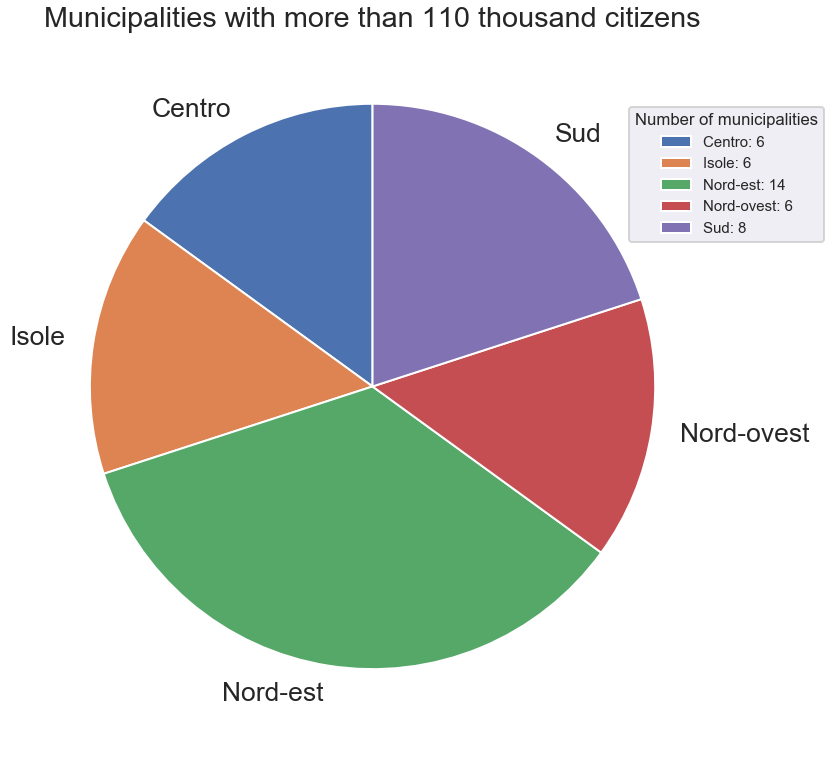

In [45]:
sns.set(style="darkgrid")
sns.set_context('poster',font_scale=1.2)
plt.figure(figsize=(18,13))
labels=[]
for i in range(len(big_municipalities['number of municipalities'].values.tolist())):
    res=str(big_municipalities['geographical area'][i])+': '+str(big_municipalities['number of municipalities'].values.tolist()[i])
    labels.append(res)
    
patches, texts = plt.pie(big_municipalities['number of municipalities'],labels=big_municipalities['geographical area'], startangle=90)
plt.legend(patches, labels, loc="right", prop={'size': 15}, bbox_to_anchor=(0.15,0.3,1,1), title="Number of municipalities", title_fontsize='xx-small')
plt.title("Municipalities with more than 110 thousand citizens")

plt.savefig("big_municipalities.png")

As we can see, the majority of municipalities with at least 110k citizens are in the North (50%).

In [46]:
df_elezioni=pd.read_csv("scrutini-camera.csv",encoding='iso-8859-1',sep=";")
#df_elezioni=df_elezioni.reset_index()
df_elezioni=df_elezioni.rename(columns={"Ente":"Regione"})
df_elezioni=df_elezioni.iloc[:,[0,4]].dropna(subset=['Percentuale votanti']).reset_index().iloc[:,1:]
df_elezioni.head()

Regione Percentuale votanti
0               Piemonte         0,751818393
1              Lombardia         0,768725605
2                 Veneto          0,78734771
3  Friuli-Venezia Giulia         0,751231846
4                Liguria         0,719858479

In [47]:
df_elezioni['Percentuale votanti']=df_elezioni['Percentuale votanti'].apply(lambda x: float(x.replace(",",".")))
df_elezioni=df_elezioni.set_index(keys="Regione")
df_elezioni['Percentuale votanti'] = df_elezioni['Percentuale votanti'] - df_elezioni['Percentuale votanti'].mean()
df_elezioni.rename_axis(mapper={'Percentuale votanti':'Standard_voters_percentage'}, axis=1, inplace=True)
df_elezioni=df_elezioni.iloc[:,0]
elezioni=df_elezioni.sort_values(ascending=False).reset_index()
elezioni['Standard_voters_percentage']=elezioni['Standard_voters_percentage'].apply(lambda x: round(x,4)*100) # rounding standardized values
elezioni['Regione']=elezioni[['Regione']].replace(to_replace="Trentino-Alto Adige/Südtirol", value='Trentino')
elezioni['Regione']=elezioni[['Regione']].replace(to_replace="Valle d'Aosta/Vallée d'Aoste", value="Valle d'Aosta")
elezioni

C:\Users\vitto\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  after removing the cwd from sys.path.


Regione  Standard_voters_percentage
0                  Veneto                        5.94
1          Emilia-Romagna                        5.50
2                  Umbria                        5.44
3                 Toscana                        4.68
4                  Marche                        4.50
5               Lombardia                        4.08
6                 Abruzzo                        2.46
7                Piemonte                        2.39
8   Friuli-Venezia Giulia                        2.33
9                Trentino                        1.55
10                  Lazio                       -0.09
11          Valle d'Aosta                       -0.52
12                Liguria                       -0.80
13                 Molise                       -1.16
14             Basilicata                       -1.68
15                 Puglia                       -3.71
16               Campania                       -4.48
17               Sardegna                       -7.28
18               Calabria                       -9.15
19                Sicilia                      -10.00

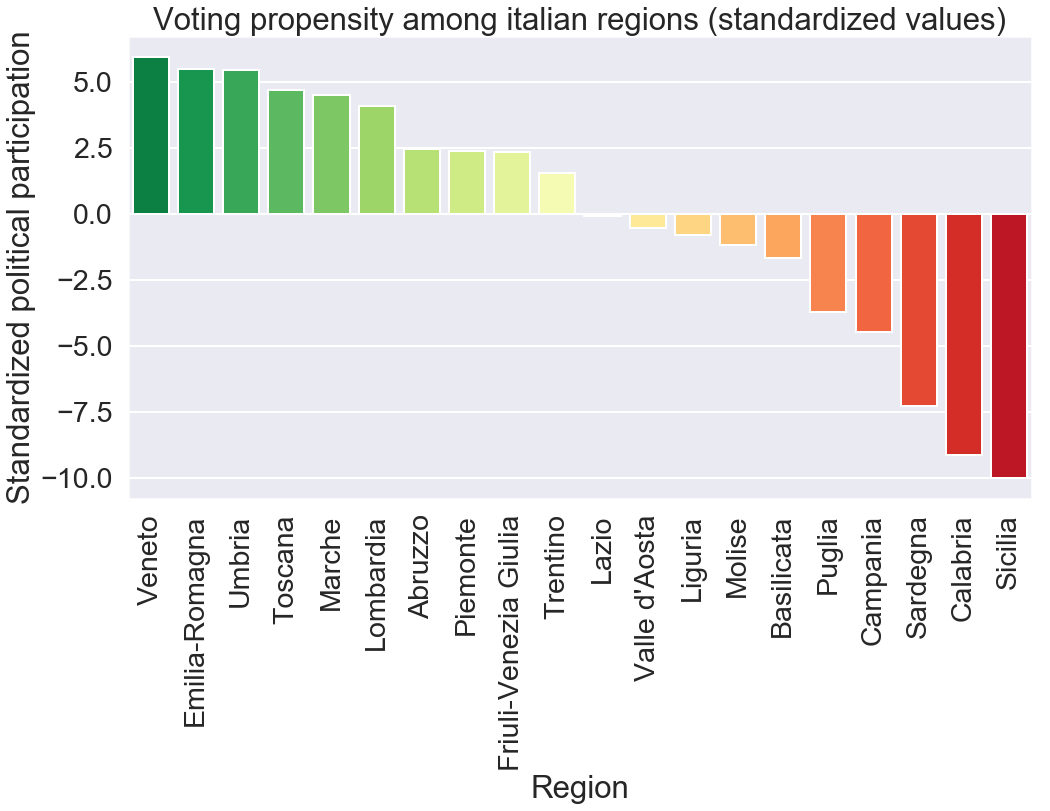

In [48]:
sns.set(style="darkgrid")
sns.set_context('poster',font_scale=1.3)
plt.figure(figsize=(15,12))

graph=sns.barplot(x=elezioni['Regione'], y=elezioni['Standard_voters_percentage'],palette="RdYlGn_r", saturation=1)

#elezioni_barplot=sns.barplot(x=elezioni.index, y=elezioni, palette="RdYlGn_r", saturation=1)
graph.set_xticklabels(elezioni['Regione'], rotation=90)

#for index, row in elezioni.iterrows():
 #   graph.text(x=row.name,y=row.Standard_voters_percentage,s=str(round(row.Standard_voters_percentage,2)) + "%", color='black', ha="center",fontsize=15)
plt.xlabel("Region")
plt.ylabel("Standardized political participation")
plt.title("Voting propensity among italian regions (standardized values)")
plt.tight_layout()
plt.savefig("Voting_propensity.png")

Based on these considerations, it is reasonable to start mainly from North Italy (more in detail, in regions with above-than-average voting participation) and target the cities with population above the 0.5% percentile.

### 5.1 Choosing the target Municipalities

#### TAM SAM SOM definition
-TAM, SAM and SOM are acronyms that represents different subsets of a market.

1) TAM or Total Available Market is the total market demand for a product or service.

2) SAM or Serviceable Available Market is the segment of the TAM targeted by your products and services which is within your geographical reach.

3) SOM or Serviceable Obtainable Market is the portion of SAM that you can capture.

The target municipalities are those in North Italy in the top 0.5% percentile.

To estimate the number of downloads obtainable we apply the average conversion rate of Comuni-chiamo to our target.

In [49]:
df_final[df_final['Percentuale votanti']>df_final['Percentuale votanti'].mean()]

Comune Ripartizione geografica  \
0               Abano Terme                Nord-est   
1           Abbadia Cerreto              Nord-ovest   
2           Abbadia Lariana              Nord-ovest   
3     Abbadia San Salvatore                  Centro   
5                Abbateggio                     Sud   
6             Abbiategrasso              Nord-ovest   
7        Abetone Cutigliano                  Centro   
11                 Acceglio              Nord-ovest   
13                  Acciano                     Sud   
25              Acquafredda              Nord-ovest   
26               Acqualagna                  Centro   
27     Acquanegra Cremonese              Nord-ovest   
28    Acquanegra sul Chiese              Nord-ovest   
33         Acquasanta Terme                  Centro   
34              Acquasparta                  Centro   
36         Acquaviva Picena                  Centro   
41              Acqui Terme              Nord-ovest   
46       Adrara San Martino              Nord-ovest   
47         Adrara San Rocco              Nord-ovest   
48                    Adria                Nord-est   
49                     Adro              Nord-ovest   
50                     Affi                Nord-est   
54                 Agazzano                Nord-est   
58                  Agliana                  Centro   
59            Agliano Terme              Nord-ovest   
61                    Agliè              Nord-ovest   
62                     Agna                Nord-est   
63                Agnadello              Nord-ovest   
66                 Agnosine              Nord-ovest   
67                   Agordo                Nord-est   
...                     ...                     ...   
7826                Zeccone              Nord-ovest   
7828                 Zelbio              Nord-ovest   
7829      Zelo Buon Persico              Nord-ovest   
7830                   Zeme              Nord-ovest   
7831              Zenevredo              Nord-ovest   
7832        Zenson di Piave                Nord-est   
7833                  Zerba                Nord-est   
7834                  Zerbo              Nord-ovest   
7835                Zerbolò              Nord-ovest   
7837                   Zeri                  Centro   
7838             Zermeghedo                Nord-est   
7839            Zero Branco                Nord-est   
7840                  Zevio                Nord-est   
7841       Ziano Piacentino                Nord-est   
7842        Ziano di Fiemme                Nord-est   
7843     Zibido San Giacomo              Nord-ovest   
7845                Zimella                Nord-est   
7846                 Zimone              Nord-ovest   
7847                Zinasco              Nord-ovest   
7849                  Zocca                Nord-est   
7850                  Zogno              Nord-ovest   
7851           Zola Predosa                Nord-est   
7853                   Zone              Nord-ovest   
7854                Zoppola                Nord-est   
7855        Zoppè di Cadore                Nord-est   
7856              Zovencedo                Nord-est   
7857                Zubiena              Nord-ovest   
7859               Zugliano                Nord-est   
7860                 Zuglio                Nord-est   
7861               Zumaglia              Nord-ovest   

                           Regione        Provincia Popolazione  distribution  \
0                           Veneto           Padova       20101      0.243368   
1                        Lombardia             Lodi         289      0.254943   
2                        Lombardia            Lecco        3216      0.235895   
3                          Toscana            Siena        6325      0.237021   
5                          Abruzzo          Pescara         371      0.244505   
6                        Lombardia           Milano       32737      0.254778   
7                          Toscana         

### These are the cities we want to enter in:

In [50]:
target=df_final[(df_final['Popolazione']>np.quantile(threshold['Popolazione'], 0.995))&(df_final['Percentuale votanti']>df_final['Percentuale votanti'].mean())].sort_values(by="Potential app users",ascending=False)
target["Service Obtainable Market"]=round(target['Potential app users']*conversion_rates[1],0).apply(lambda x: int(x))
target.iloc[:,[0,4,8,9]]

Comune Popolazione  Potential app users  \
3967              Milano     1366180               267573   
7096              Torino      882523               156594   
734              Bologna      389261                74917   
2730             Firenze      380948                69856   
7547              Verona      257275                50778   
7512             Venezia      261321                47442   
4767              Padova      210440                40323   
4857               Parma      195687                39122   
5382               Prato      193325                38094   
892              Brescia      196745                37957   
4006              Modena      185273                35836   
5534  Reggio nell'Emilia      171944                34039   
7253             Trieste      204338                33713   
4961             Perugia      165683                31663   
5514             Ravenna      159115                28973   
5581              Rimini      149403                28929   
3521             Livorno      158371                27821   
4355               Monza      123598                23316   
636              Bergamo      120923                23173   
2683             Ferrara      132278                22910   
2805               Forlì      117863                22305   
4965             Pescara      119217                21936   
7590             Vicenza      111620                21162   
7219              Trento      117997                21109   

      Service Obtainable Market  
3967                      20471  
7096                      11980  
734                        5732  
2730                       5344  
7547                       3885  
7512                       3630  
4767                       3085  
4857                       2993  
5382                       2914  
892                        2904  
4006                       2742  
5534                       2604  
7253                       2579  
4961                       2422  
5514                       2217  
5581                       2213  
3521                       2128  
4355                       1784  
636                        1773  
2683                       1753  
2805                       1706  
4965                       1678  
7590                       1619  
7219                       1615

In [51]:
print("Our potential market in the whole country is:",df_final['Potential app users'].sum(),"people.")
print("Our service addressable market (people btw 25 and 44 interested in politics in big cities with high voting participation) is:",target.iloc[:,[0,4,8,9]]['Potential app users'].sum())
print("Our service obtainable market (people btw 25 and 44 interested in politics in big cities with high voting participation) is:",target.iloc[:,[0,4,8,9]]['Service Obtainable Market'].sum())

Our potential market in the whole country is: 10890652 people.
Our service addressable market (people btw 25 and 44 interested in politics in big cities with high voting participation) is: 1199541
Our service obtainable market (people btw 25 and 44 interested in politics in big cities with high voting participation) is: 91771
